# 스터디 2주차 : Optimazation 및 Regression

- [Kaggle : Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- [Kaggle Clone Coding Notebook](https://www.kaggle.com/omarelgabry/a-journey-through-titanic)

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
train=pd.read_csv('C:/Users/yoonj/Desktop/kaggle_study/2주차/train.csv')
test=pd.read_csv('C:/Users/yoonj/Desktop/kaggle_study/2주차/test.csv')

------------
## Part1. EDA

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [4]:
train=train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test=test.drop(['Name', 'Ticket'], axis=1)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [5]:
#train 데이터셋 결측치 확인
train.isnull().sum() 

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

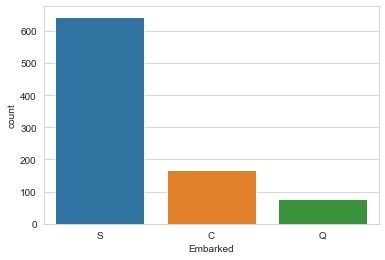

In [6]:
sns.countplot('Embarked',data=train)

In [7]:
#embarked 변수의 missing value 처리 - 대부분의 승객이 'S'에서 탑승하였으므로, S로 대체
train['Embarked']=train['Embarked'].fillna('S')

train.isnull().sum()  #embarked 변수의 결측치 개수가 0으로 변화

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      0
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


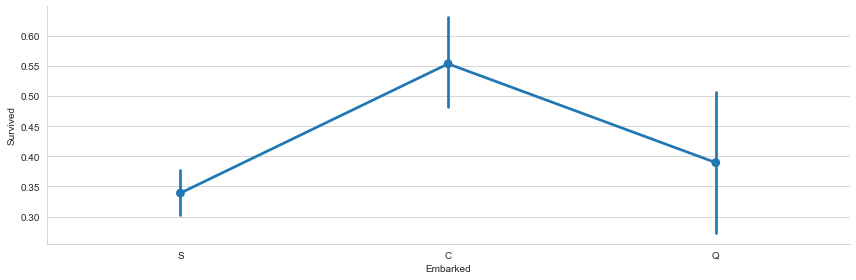

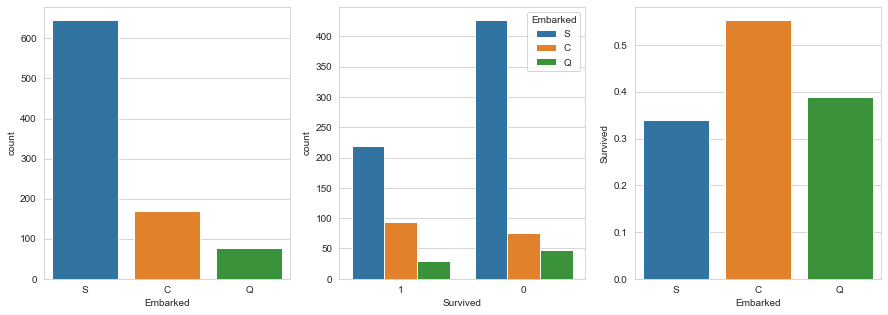

In [8]:
#embarked - survived 변수 간 관계 시각화(그래프)
sns.factorplot('Embarked','Survived', data=train, size=4, aspect=3)

fig,ax = plt.subplots(1,3,figsize=(15,5))  #plot field

sns.countplot(x='Embarked', data=train, ax=ax[0])  #embarked 변수 분포
sns.countplot(x='Survived', hue="Embarked", data=train, order=[1,0], ax=ax[1])  #survived 변수에 따른 embarked 변수의 분포

embark_perc = train[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=ax[2])  #embarked 변수의 평균 생존률

In [9]:
#Embarked 변수 더미변수환
embark_train = pd.get_dummies(train['Embarked'])
embark_train.drop(['S'], axis=1, inplace=True)

embark_test = pd.get_dummies(test['Embarked'])
embark_test.drop(['S'], axis=1, inplace=True)

train=train.join(embark_train)
test=test.join(embark_test)

train.drop(['Embarked'], axis=1, inplace=True)
test.drop(['Embarked'], axis=1, inplace=True)

In [10]:
#fare - missing value (1개) 처리
test['Fare'].fillna(test['Fare'].median(), inplace=True)

test.isnull().sum()  #Fare 변수의 결측치 개수가 0으로 변화

PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             0
Cabin          327
C                0
Q                0
dtype: int64

In [11]:
#fare 변수의 자료형 float형에서 int형으로 변환
train['Fare'] = train['Fare'].astype(int)
test['Fare'] = test['Fare'].astype(int)

In [12]:
#생존자와 사망자의 탑승료(fare)로 구분 후 평균과 표준편차 구함
fare_0 = train['Fare'][train['Survived']==0]
fare_1 = train['Fare'][train['Survived']==1]

avg_fare = DataFrame([fare_0.mean(), fare_1.mean])
std_fare = DataFrame([fare_0.std(), fare_1.std()])

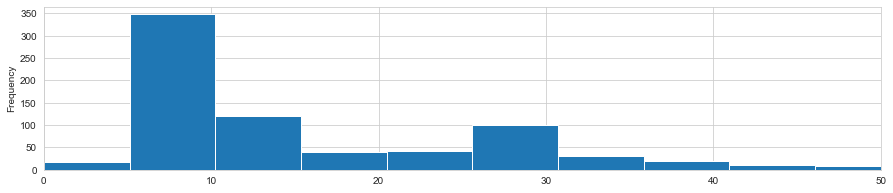

In [13]:
#fare 변수의 시각화(plot)
train['Fare'].plot(kind='hist', figsize=(15, 3), bins=100, xlim=(0, 50))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


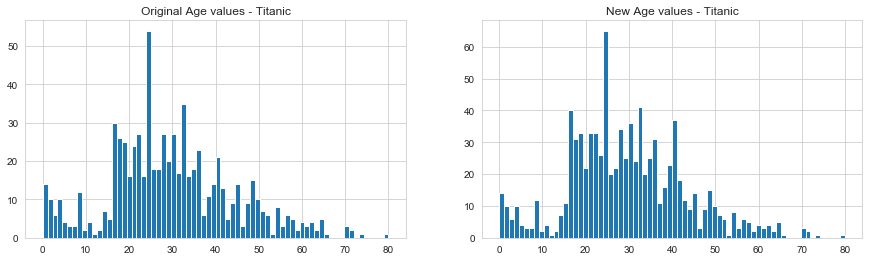

In [14]:
#Age 변수의 기초 통계량 - train
avg_age = train["Age"].mean()
std_age = train["Age"].std()
cnt_age_NA = train["Age"].isnull().sum()

#Age 변수의 기초 통계량 - test
avg_age_test = test["Age"].mean()
std_age_test = test["Age"].std()
cnt_age_NA_test = test["Age"].isnull().sum()

#[(mean-std), (mean+std)] 사이의 난수 생성
rand1 = np.random.randint(avg_age-std_age, avg_age+std_age, size = cnt_age_NA)
rand2 = np.random.randint(avg_age_test-std_age_test, avg_age_test+std_age_test, size = cnt_age_NA_test)

#Age 변수 시각화(plot)
fig,ax = plt.subplots(1,2,figsize=(15,4))

ax[0].set_title('Original Age values - Titanic')
ax[1].set_title('New Age values - Titanic')

train['Age'].dropna().astype(int).hist(bins=70, ax=ax[0])  #raw 데이터셋의 age 시각화

#age - missing value (1개) 처리 >> 생성된 난수 기반
train['Age'][np.isnan(train['Age'])]=rand1
test['Age'][np.isnan(test['Age'])]=rand2

#Age 변수 자료형 변환
train['Age']=train['Age'].astype(int)
test['Age']=test['Age'].astype(int)

train['Age'].hist(bins=70, ax=ax[1])  #결측치 처리된 데이터셋의 age 시각화

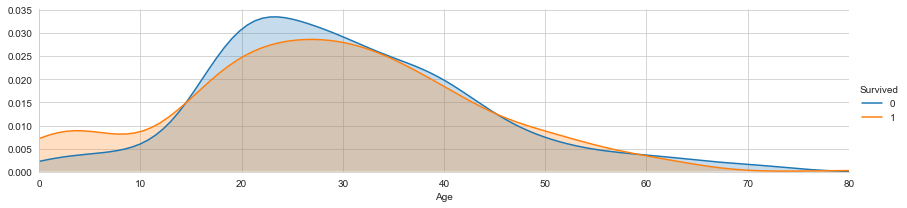

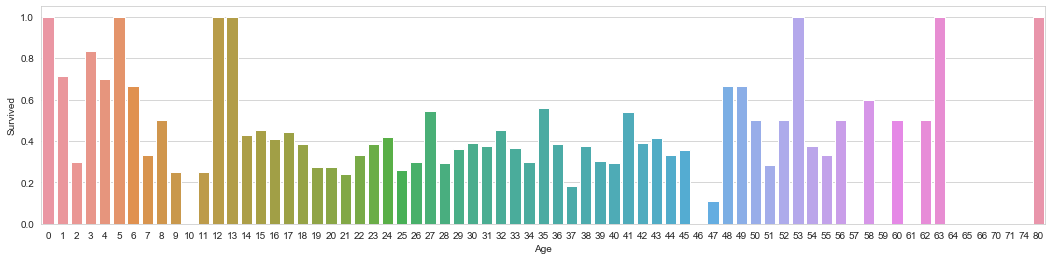

In [15]:
#age - survived 변수 시각화(plot)
facet=sns.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

# 연령별 생존자 수  시각화
fug, ax=plt.subplots(1, 1, figsize=(18,4))
avg_age = train[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=avg_age)

In [16]:
#Cabin 변수는 결측치가 매우 많으므로, 사용하지 않기로 결정
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [17]:
#Parch & SibSp >> Family 변수로 대체
train['Family'] = train['Parch']+train['SibSp']
train['Family'].loc[train['Family']>0]=1
train['Family'].loc[train['Family']==0]=0

test['Family'] = test['Parch']+test['SibSp']
test['Family'].loc[test['Family']>0]=1
test['Family'].loc[test['Family']==0]=0

train.drop('Parch', axis=1, inplace=True)
test.drop('Parch', axis=1, inplace=True)

train.drop('SibSp', axis=1, inplace=True)
test.drop('SibSp', axis=1, inplace=True)

train

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Survived,Pclass,Sex,Age,Fare,C,Q,Family
0,0,3,male,22,7,0,0,1
1,1,1,female,38,71,1,0,1
2,1,3,female,26,7,0,0,0
3,1,1,female,35,53,0,0,1
4,0,3,male,35,8,0,0,0
...,...,...,...,...,...,...,...,...
886,0,2,male,27,13,0,0,0
887,1,1,female,19,30,0,0,0
888,0,3,female,40,23,0,0,1
889,1,1,male,26,30,1,0,0


[Text(0, 0, 'With Faily'), Text(0, 0, 'Alone')]

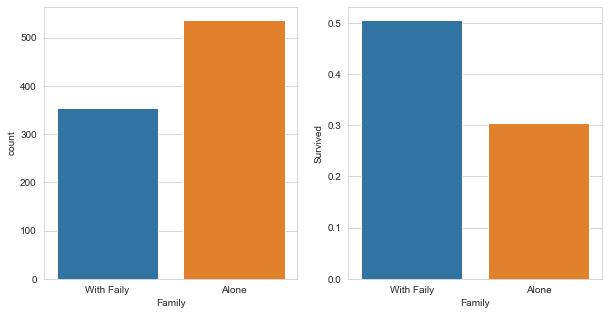

In [18]:
#Family 변수 시각화(plot)
fig,ax = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

sns.countplot(x='Family', data=train, order=[1,0],ax=ax[0]) #family 변수 분포 시각화

family_prec=train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_prec, order=[1,0], ax=ax[1])  #family 변수의 평균 생존률 

ax[1].set_xticklabels(["With Faily", "Alone"], rotation=0)

In [19]:
#sex 변수 세분화
#age 변수 EDA를 통해 나이가 어릴 수록 (<16) 생존률이 높은 것을 확인할 수 있었다. 따라서, 성별은 남성/여성/어린이로 구분
def get_person(passenger):
    age, sex=passenger
    if age<16:
        return 'child' 
    else:
        return sex
    
train['Person'] = train[['Age', 'Sex']].apply(get_person, axis=1)
test['Person'] = test[['Age', 'Sex']].apply(get_person, axis=1)

train.drop(['Sex'], axis=1, inplace=True)
test.drop(['Sex'], axis=1, inplace=True)

In [20]:
#Person 변수 >> 더미 변수화 + '남성'의 경우 생존률이 낮으므로 person==male이면 삭제
person_train = pd.get_dummies(train['Person'])
person_train.columns=['Child', 'Female', 'Male']
person_train.drop(['Male'], axis=1, inplace=True)

person_test = pd.get_dummies(test['Person'])
person_test.columns=['Child', 'Female', 'Male']
person_test.drop(['Male'], axis=1, inplace=True)

train=train.join(person_train)
test=test.join(person_test)

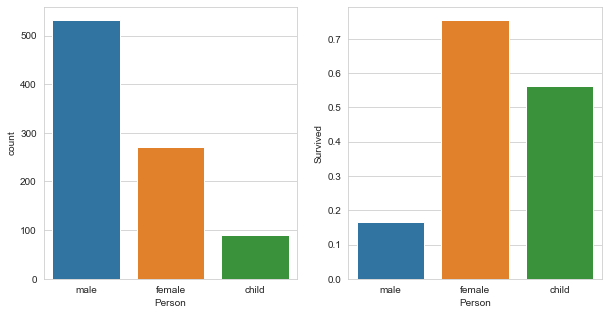

In [21]:
#Person 변수 시각화(plot)
fig,ax=plt.subplots(1, 2, figsize=(10,5))

sns.countplot(x='Person', data=train, ax=ax[0])  #person 변수의 분포 시각화

person_prec=train[['Person', 'Survived']].groupby(['Person'], as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_prec, ax=ax[1], order=['male', 'female', 'child'])  #각 성별의 평균 생존률

train.drop(['Person'], axis=1, inplace=True)
test.drop(['Person'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


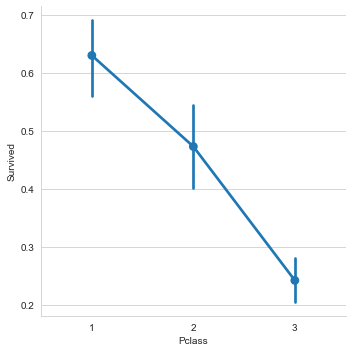

In [22]:
#pclass
sns.factorplot('Pclass','Survived', order=[1,2,3], data=train, size=5)

#pcalss 변수 더미변수화
pclass_train = pd.get_dummies(train['Pclass'])
pclass_train.columns=['Class1', 'Class2', 'Class3']
pclass_train.drop(['Class3'], axis=1, inplace=True)

pclass_test = pd.get_dummies(test['Pclass'])
pclass_test.columns=['Class1', 'Class2', 'Class3']
pclass_test.drop(['Class3'], axis=1, inplace=True)

train.drop(['Pclass'], axis=1, inplace=True)
test.drop(['Pclass'], axis=1, inplace=True)

train=train.join(pclass_train)
test=test.join(pclass_test)

-----
## Part2. Modeling 
### 1. Logistic Regression

In [23]:
#train, test 데이터셋 정의
x_train = train.drop('Survived', axis=1)
y_train = train['Survived']

x_test = test.drop('PassengerId', axis=1).copy()

In [24]:
x_train

,Age,Fare,C,Q,Family,Child,Female,Class1,Class2
0,22,7,0,0,1,0,0,0,0
1,38,71,1,0,1,0,1,1,0
2,26,7,0,0,0,0,1,0,0
3,35,53,0,0,1,0,1,1,0
4,35,8,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
886,27,13,0,0,0,0,0,0,1
887,19,30,0,0,0,0,1,1,0
888,40,23,0,0,1,0,1,0,0
889,26,30,1,0,0,0,0,1,0


In [25]:
#Logistic Regression
logist = LogisticRegression()
logist.fit(x_train, y_train)

y_pred = logist.predict(x_test)
logist.score(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8092031425364759

-------------
### 2. Support Vector Machine (SVM)

In [26]:
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
svc.score(x_train, y_train)

0.6801346801346801

-----
### 3. Random Forest (RF)

In [28]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_pred=rf.predict(x_test)
rf.score(x_train, y_train)

0.9640852974186308

-----
### 4. K-Nearest Neighbor (KNN)

In [29]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred=knn.predict(x_test)
knn.score(x_train, y_train)

0.8271604938271605

------
### 5. Gaussian Naive Bayes

In [31]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred=gaussian.predict(x_test)
gaussian.score(x_train, y_train)

0.755331088664422

------------

In [37]:
#logistic regression을 사용했을 대, 각 변수의 coefficient
coeff=DataFrame(train.columns.delete(0))  #'Survived' 변수는 종속 변수이므로 제거 
coeff.cloumns=['Features']

coeff["coefficient estimate"] = pd.Series(logist.coef_[0])

coeff

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


,0,coefficient estimate
0,Age,-0.025237
1,Fare,0.000775
2,C,0.601781
3,Q,0.255197
4,Family,-0.220326
5,Child,1.787521
6,Female,2.799512
7,Class1,2.094632
8,Class2,1.140303


In [38]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred #마지막으로 정의한 y_pred = GaussianNB()
    })

In [39]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
